In [1]:

import pandas as pd
import qiime2 as q2
from biom import Table, load_table
import glob
import numpy as np
from qiime2.plugins.phylogeny.methods import filter_table
from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (ctf, rpca,
                                            phylogenetic_ctf_without_taxonomy,
                                            phylogenetic_rpca_without_taxonomy)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.feature_table.methods import rarefy, filter_samples, filter_features
from skbio.stats.distance import permanova
from qiime2.plugins.longitudinal.actions import first_distances

import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
import itertools
from scipy.stats import mannwhitneyu

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:


"""
Export data for R.
"""
# get metdata
metadata = pd.read_csv('../data/matched-data/without-csf/metadata.tsv', sep='\t', index_col=0)
gotu_taxonomy = pd.read_csv('../data/wol/wol_gotu_metadata.tsv', sep='\t', index_col=0)
gotu_taxonomy = gotu_taxonomy[~gotu_taxonomy.genus.isin(['Klebsiella','Shigella','Yersinia','Haemophilus','Pseudomonas'])]
gotu_coverage = pd.read_csv('../data/metaG/coverage.tsv', sep='\t', index_col=0)
gotu_coverage_keep = gotu_coverage[gotu_coverage.coverage_ratio > 0.1].index
# remove subject with one timepoint
metadata = metadata[~metadata.SubjectID.isin(['3JEBA000908'])]
# get tables
# load nightingale data
bt_night = load_table('../data/matched-data/without-csf/table-nightingale-serum.biom')
df_night = bt_night.to_dataframe()
# map names and add microbiome data
bt_microbe = load_table('../data/metaG/metaG-matched-table.biom')
metadata_map = pd.read_csv('../data/metabolomics/BEAM_metadata_KAW.csv', index_col='Sample.Barcode')
metadata_map.index = metadata_map.index.astype(str)
metadata_map.index = '13662.' + metadata_map.index.astype(str)
metadata_map.index.name = 'sampleid'
metadata_map['timepoint_encoded'] = metadata_map['Study_TP'].astype(int)
metadata_map['subject_time'] = metadata_map['SubjectID'] + '_' + metadata_map.timepoint_encoded.astype(int).astype(str)
map_to_subject_time = metadata_map['subject_time'].to_dict()
df_microbe = bt_microbe.to_dataframe()
df_microbe = df_microbe[set(df_microbe.columns) & set(map_to_subject_time.keys())]
df_microbe.columns = [map_to_subject_time[x] for x in df_microbe.columns]
df_microbe = df_microbe.loc[set(gotu_coverage_keep) & set(df_microbe.index) & set(gotu_taxonomy.index), :]
# match all 
shared = set(metadata.index) & set(df_night.columns) & set(df_microbe.columns)
metadata = metadata.reindex(shared)
df_night = df_night[metadata.index]
df_microbe = df_microbe[metadata.index]
# save for JOINT-TENSOR
df_night.to_csv('../data/matched-data/without-csf/table-nightingale-serum-joint-tensors.tsv', sep='\t')
df_microbe.to_csv('../data/matched-data/without-csf/table-microbiome-fecal-joint-tensors.tsv', sep='\t')
metadata.to_csv('../data/matched-data/without-csf/metadata-joint-tensors.tsv', sep='\t')


#### Then we run the R code joint_tensor_factorization_microbiome_nightingale.R

In [3]:
"""
Grab Joint-TEMPTED results.
"""

# add subject metdata
subject_loading = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/a_hat.csv', index_col=0)
metadata_subject = metadata.groupby('SubjectID').first()
subject_loading_meta = subject_loading.copy()
subject_loading_meta['cog'] = metadata_subject[['cog']].reindex(subject_loading.index).values
# import loadings and make covariance and corr. matrix
metab_loading = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/b_hat.csv', index_col=0)
microbe_loading = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/b_two_hat.csv', index_col=0)
time_loading_metab = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/phi_hat.csv', index_col=0)
time_loading_microbe = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/phi_two_hat.csv', index_col=0)
lambda_metab = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/lambda.csv', index_col=0)
lambda_microbe = pd.read_csv('../results/joint-tensor-factor-microbiome-nightingale/lambda_two.csv', index_col=0)
W_metab = np.diag(lambda_metab.values.ravel()) @ metab_loading.values.T
W_microbe = np.diag(lambda_microbe.values.ravel()) @ microbe_loading.values.T
W = np.hstack([W_metab, W_microbe]).T
covariance = (W @ W.T)
feature_labels = list(metab_loading.index) + list(microbe_loading.index)
covariance = pd.DataFrame(covariance,
                          feature_labels,
                          feature_labels)
# cov. to corr.
v = np.sqrt(np.diag(covariance))
outer_v = np.outer(v, v)
correlation = covariance / outer_v
correlation[covariance == 0] = 0
# convert back to dataframe
correlation = pd.DataFrame(correlation,
                           covariance.index,
                           covariance.columns)
correlation.index.name = 'featureid'


In [4]:
correlation.to_csv('../results/figures/correlation-tensor-nightingale-microbiome.csv')

In [5]:
# add corr for leucine
bcaa = ['Val','Ile','Leu']
bcaa_cov = [x + '_cov' for x in bcaa]
corr_leu = correlation.loc[microbe_loading.index, bcaa]
corr_leu[bcaa_cov] = covariance.loc[corr_leu.index, bcaa]
diffs_microbes = pd.read_csv('../results/differential-abundances/table-microbiome-fecal.beta_var.tsv', sep='\t', index_col=0)
corr_leu = pd.concat([corr_leu, diffs_microbes, gotu_taxonomy, gotu_coverage], axis=1).dropna(subset=bcaa)

# each genome prot
genome_to_prot = pd.read_csv('../data/wol/metacyc/protein.map.xz', sep='\t', header=None)
# prot to enzrxn
prot_to_enzrxn_file = open('../data/wol/metacyc/protein-to-gene.txt', 'r')
prot_to_enzrxn = [[l.lstrip().rstrip().replace('\n', '') for l in line.split('\t')] 
                  for line in prot_to_enzrxn_file]
prot_to_enzrxn_file.close()
prot_to_enzrxn_map = {names_tmp[0]:names_tmp[1:] for names_tmp in prot_to_enzrxn}
genome_to_prot[2] = [prot_to_enzrxn_map[v] if v in prot_to_enzrxn_map.keys() else np.nan for v in genome_to_prot[1]]
genome_to_prot = genome_to_prot.dropna(subset=[2])
# add gene function to annotation
gene_names = pd.read_csv('../data/wol/metacyc/gene_name.txt', sep='\t', header=None)
gene_names_check = ['ilvB', 'ilvC', 'ilvD', 'ilvN']
for gene_ in gene_names_check:
    tmp_genes = list(gene_names[gene_names[1].isin(['ilvB', 'ilvC', 'ilvD', 'ilvN'])][0])
    tmp_genes_genomes = genome_to_prot.loc[[any(y in x for y in tmp_genes) for x in genome_to_prot[2]], :]
    tmp_genes_genomes_set = set([x.split('_')[0] for x in tmp_genes_genomes[0]]) & set(corr_leu.index)
    corr_leu[gene_] = False
    corr_leu.loc[tmp_genes_genomes_set, gene_] = True
corr_leu['all_gene_coverage'] = (corr_leu[gene_names_check].astype(bool).sum(1)/ len(gene_names_check)) * 100
corr_leu['all_genes'] = False
corr_leu.loc[corr_leu[corr_leu['all_gene_coverage'] == 100].index, 'all_genes'] = True
corr_leu = corr_leu[corr_leu.draft_quality == 'high']

# view result
corr_leu_subset = corr_leu[bcaa + ['diet_nocross[T.Ketogenic Diet]_mean', 'cog[T.NC]_mean',
                            'diet_nocross[T.Ketogenic Diet]_std', 'cog[T.NC]_std','coverage_ratio',
                            'species','organism_name','assembly_accession','all_gene_coverage'] + gene_names_check]
corr_leu_subset['bcaa'] =  corr_leu_subset[bcaa].mean(1)

corr_leu_subset.head(2)


/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Val,Ile,Leu,diet_nocross[T.Ketogenic Diet]_mean,cog[T.NC]_mean,diet_nocross[T.Ketogenic Diet]_std,cog[T.NC]_std,coverage_ratio,species,organism_name,assembly_accession,all_gene_coverage,ilvB,ilvC,ilvD,ilvN,bcaa
G000006865,-0.023668,0.155368,0.121938,0.493086,0.620899,0.447470,0.961889,0.928486,Lactococcus lactis,Lactococcus lactis subsp. lactis Il1403,GCF_000006865.1,100.0,True,True,True,True,0.084546
G000007265,-0.406699,-0.357492,-0.416875,-0.280863,-0.540991,0.240014,0.892332,0.113171,Streptococcus agalactiae,Streptococcus agalactiae 2603V/R,GCF_000007265.1,0.0,False,False,False,False,-0.393689


/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


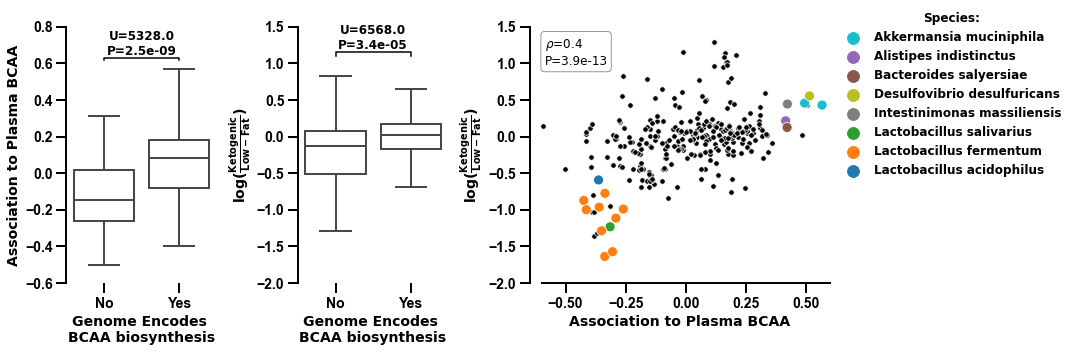

In [11]:
from matplotlib.pyplot import cm
from scipy.stats import ttest_ind
from scipy.stats import spearmanr

# plot association with biosynthesis

corr_leu_subset_sp = corr_leu_subset
#.groupby('species').median()
corr_leu_subset_sp['all_genes_bool'] = 'No'
corr_leu_subset_sp.loc[corr_leu_subset_sp[corr_leu_subset_sp['all_gene_coverage'] == 100].index, 'all_genes_bool'] = 'Yes'
#corr_leu_subset_sp_ = corr_leu_subset_sp[corr_leu_subset_sp['Leu'] > 0]
corr_leu_subset_sp_ = corr_leu_subset_sp.copy()
#corr_leu_subset_sp_ = corr_leu_subset_sp[corr_leu_subset_sp['diet_nocross[T.Ketogenic Diet]_mean'].abs() < 2]

diff_plot = {"CN:MCI":"cog[T.NC]_mean",
             "Keto&CN:all-others":"diet_nocross_keto_cog_mean",
             "Ketogenic:Low-Fat":"diet_nocross[T.Ketogenic Diet]_mean"}
diff_plot_rev = {v:k for k, v in diff_plot.items()}

x_ = 'bcaa'
y_ = 'diet_nocross[T.Ketogenic Diet]_mean'
hue_ = 'all_genes_bool'

fig, axn = plt.subplots(1, 3, figsize=(15,5), gridspec_kw={'width_ratios': [1, 1, 2]})

sns.boxplot(x=hue_, y=x_, data=corr_leu_subset_sp_, order=['No','Yes'], showfliers=False, ax=axn[0], linewidth=2)
axn[0].set_ylabel('Association to Plasma BCAA',
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[0].set_xlabel('Genome Encodes \nBCAA biosynthesis',
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[0].set_ylim(-0.6, 0.8)

sns.boxplot(x=hue_, y=y_, data=corr_leu_subset_sp_, order=['No','Yes'], showfliers=False, ax=axn[1], linewidth=2)
label = diff_plot_rev[y_]
title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
axn[1].set_ylabel(title_,
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[1].set_xlabel('Genome Encodes \nBCAA biosynthesis',
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[1].set_ylim(-2, 1.5)

#sns.regplot(x=x_, y=y_, data=corr_leu_subset_sp_, ax=axn[3])
sns.scatterplot(x=x_, y=y_, data=corr_leu_subset_sp_, color='black', s=30, ax=axn[2])
corr_leu_subset_sp_high = corr_leu_subset_sp_[(corr_leu_subset_sp_['bcaa'] > 0.4) & (corr_leu_subset_sp_['diet_nocross[T.Ketogenic Diet]_mean'] > 0.1)].drop(['G000980515'])
corr_leu_subset_sp_low = corr_leu_subset_sp_[(corr_leu_subset_sp_['bcaa'] < -.2) & (corr_leu_subset_sp_['diet_nocross[T.Ketogenic Diet]_mean'] < -0.5)]
#all_spp = list(set(corr_leu_subset_sp_high.species)) + list(set(corr_leu_subset_sp_low.species))
#color = cm.Set1(np.linspace(0, 1, 9))
corr_leu_subset_sp_low = corr_leu_subset_sp_low[corr_leu_subset_sp_low.all_genes_bool == 'No']
corr_leu_subset_sp_highlow = pd.concat([corr_leu_subset_sp_high, corr_leu_subset_sp_low])
all_spp = corr_leu_subset_sp_highlow.groupby('species').mean().sort_values('bcaa').index
color = cm.tab10(np.linspace(0, 1, len(all_spp)))
cmap_ = {i:c for i, c in zip(all_spp, color)}
sns.scatterplot(x=x_, y=y_, hue='species', palette=cmap_, 
                data=corr_leu_subset_sp_highlow, color='black', s=100, ax=axn[2])


label = diff_plot_rev[y_]
title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
axn[2].set_ylabel(title_,
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[2].set_xlabel('Association to Plasma BCAA',
                  color='black',
                  weight='bold',
                  fontsize=14)
axn[2].set_ylim(-2, 1.5)
axn[2].set_xlim(-0.65, 0.6)
#axn[2].legend_.remove()

ax = axn[2]
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
               loc=2, bbox_to_anchor=(1, 1.1),
                     prop={'size':12, 'weight':'bold'},
                     title="Species:", 
                     fancybox=False, framealpha=.0,
                     ncol=1, markerscale=6)
legend.get_title().set_fontsize('12')
legend.get_title().set_weight('bold')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

for ax in axn:
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
for ax in axn[:2]:    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))
        
# stats

x_ = 'bcaa'
y_ = 'diet_nocross[T.Ketogenic Diet]_mean'
hue_ = 'all_genes_bool'
a_ = corr_leu_subset_sp[corr_leu_subset_sp[hue_] == 'Yes'][x_].values
b_ = corr_leu_subset_sp[corr_leu_subset_sp[hue_] == 'No'][x_].values
s1_ = mannwhitneyu(a_, b_)
a_ = corr_leu_subset_sp[corr_leu_subset_sp[hue_] == 'Yes'][y_].values
b_ = corr_leu_subset_sp[corr_leu_subset_sp[hue_] == 'No'][y_].values
s2_ = mannwhitneyu(a_, b_)
(s1_, s2_)

ax = axn[0]
x1 = 0
x2 = 1
y, h, col = 0.62, 0.01, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
stat_ = s1_.statistic
p_ = s1_.pvalue
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "U=%.1f\nP=%s" % (stat_, p_)
else:
    p_ = "U=%.1f\nP=%.4f" % (stat_, p_)
ax.text((x1+x2) * .5, y+h+.0000001,
        p_, ha='center',fontsize=12,
        va='bottom', weight='bold', color=col)

ax = axn[1]
x1 = 0
x2 = 1
y, h, col = 1.1, 0.05, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
stat_ = s2_.statistic
p_ = s2_.pvalue
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "U=%.1f\nP=%s" % (stat_, p_)
else:
    p_ = "U=%.1f\nP=%.4f" % (stat_, p_)
ax.text((x1+x2) * .5, y+h+.0000001,
        p_, ha='center',fontsize=12,
        va='bottom', weight='bold', color=col)

scorr_ = spearmanr(corr_leu_subset_sp_[x_], corr_leu_subset_sp_[y_])
stat_ = scorr_.correlation
p_ = scorr_.pvalue
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "$\\rho$=%.1f\nP=%s" % (stat_, p_)
else:
    p_ = "$\\rho$=%.1f\nP=%.4f" % (stat_, p_)
props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
axn[2].text(0.05, 0.85, p_, fontsize=12, zorder=-1, transform=axn[2].transAxes, bbox=props)    
axn[2].grid(False)
axn[2].spines['bottom'].set_bounds(-.6, 0.6)

plt.tight_layout()
plt.savefig('../results/figures/BCAA-joint-tensor-nightingale-microbiome.png',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../results/figures/BCAA-joint-tensor-nightingale-microbiome.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [19]:
corr_leu_subset_sp__out = corr_leu_subset_sp_[[x_, y_, hue_, 'species']]
corr_leu_subset_sp__out['subset_color_spp'] = False
corr_leu_subset_sp__out.loc[corr_leu_subset_sp_highlow.index, 'subset_color_spp'] = True
corr_leu_subset_sp__out.to_csv('../results/figures/richa-plot-one-bcaa-gene-encoded.csv')
corr_leu_subset_sp__out.head(5)

/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cameronmartino/miniconda2/envs/qiime2-2019.7/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bcaa,diet_nocross[T.Ketogenic Diet]_mean,all_genes_bool,species,subset_color_spp
G000006865,0.084546,0.493086,Yes,Lactococcus lactis,False
G000007265,-0.393689,-0.280863,No,Streptococcus agalactiae,False
G000007465,-0.235073,-0.591208,Yes,Streptococcus mutans,False
G000007525,0.188100,-0.753928,Yes,Bifidobacterium longum,False
G000007785,-0.289357,-0.033792,No,Enterococcus faecalis,False


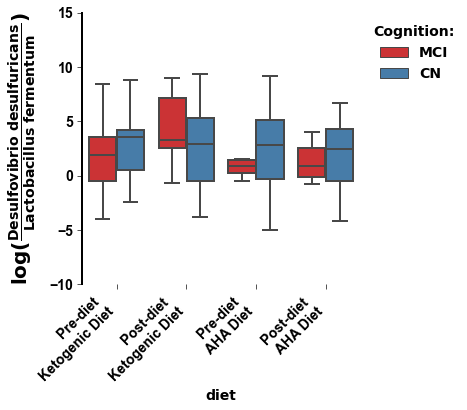

In [10]:
# explore cognition & show trends across time

# get log-ratio
gotu_taxonomy_ = gotu_taxonomy.reindex(df_microbe.index) 
num_ = corr_leu_subset_sp_high.index
den_ = corr_leu_subset_sp_low.index
num_ = num_ = gotu_taxonomy_[gotu_taxonomy_.species.isin(['Desulfovibrio desulfuricans'])].index
#den_ = corr_leu_subset_sp_highlow[corr_leu_subset_sp_highlow.species.isin(['Lactobacillus fermentum'])].index
den_ = corr_leu_subset[((corr_leu_subset.species.isin(['Lactobacillus fermentum'])) & (corr_leu_subset.all_genes_bool.isin(['Yes'])))].index
#den_ = corr_leu_subset_sp_highlow.sort_values('diet_nocross[T.Ketogenic Diet]_mean').index[:19]
min_ = df_microbe.values
min_ = min_[min_ != 0]
min_ = min_.min()
df_microbe_pc = df_microbe.copy() + 0.1
metadata_lr = metadata.copy()
lr_ = np.log(df_microbe_pc.loc[num_, :].sum(0)) - np.log(df_microbe_pc.loc[den_, :].sum(0))
metadata_lr['log_ratio'] = lr_.reindex(metadata_lr.index)

marker_map_subset = {'AB-Ratio': ['AC_14_2_'], 
                     'ADAS-COG': ['PE_P_16_0_22_6_',],
                     'Butyrylcholinesterase':['TG_58_9___NL_22_6_']}

metadata_plot = metadata_lr.copy()

# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'MCI':'#e41a1c', 'NC':'#377eb8'}

order_xaxis = ['Pre-diet \nKetogenic Diet',
                'Post-diet \nKetogenic Diet',
                'Pre-diet \nAHA Diet',
                'Post-diet \nAHA Diet']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))


relabel_ticks = {1:'Pre-diet \n', 2:'Post-diet \n', 
                 3:'Pre-diet \n', 4:'Post-diet \n', 
                 5:'Post-diet \n'}

orddf = metadata_plot.copy()
orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
orddf['p_plus_diet'] = orddf.Period + orddf.Diet

sns.boxplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
             data=orddf, palette=cmap_man, hue_order=['MCI','NC'], ax=ax, showfliers=False)
#sns.stripplot(x='p_plus_diet', y='log_ratio', hue='cog',order=order_xaxis,
#              data=orddf, palette=cmap_man, ax=ax, dodge=True, s=10)

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    tick.set_rotation(45)
    tick.set_ha('right')

ax.set_ylabel('lr',
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=14)

title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % ('Desulfovibrio\,\,desulfuricans',
                                                        'Lactobacillus\,\,fermentum')
ax.set_ylabel(title_,
                  color='black',
                  weight='bold',
                  fontsize=20)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.set_xlabel('diet',
          color='black',
          weight='bold',
          labelpad=5,
          fontsize=14)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:],
                   [l.replace('NC','CN') for l in labels[:]],
                   loc=2, 
                         bbox_to_anchor=(1, 1),
                         prop={'size':14, 'weight':'bold'},
                         title="Cognition:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('14')
legend.get_title().set_weight('bold')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
ax.set_ylim(-10, 15)
# plot tests
"""
combos_test_ = list(itertools.combinations(set(orddf['p_plus_diet']), 2))
combos_test_df = pd.DataFrame({(k, c1, c2):mannwhitneyu(df[df['p_plus_diet'] == c1]['log_ratio'],
                                                     df[df['p_plus_diet'] == c2]['log_ratio']) 
                               for k, df in orddf.groupby('cog') for c1, c2 in combos_test_}).T
combos_test_df.columns = ['T','p']
test_plot = {}
test_plot[(-0.25, 0.75, 8.9)] = combos_test_df.loc[('MCI', 'Post-diet \nKetogenic Diet', 'Pre-diet \nKetogenic Diet'), :].values
test_plot[(0.75, 1.75, 9.9)] = combos_test_df.loc[('MCI', 'Post-diet \nKetogenic Diet', 'Post-diet \nAHA Diet'), :].values
test_plot[(0.75, 2.75, 12.9)] = combos_test_df.loc[('MCI', 'Post-diet \nKetogenic Diet', 'Pre-diet \nAHA Diet'), :].values
for (x1, x2, y), (stat_, p_) in test_plot.items():
    h, col = 0.5, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    #stat_ = s2_.statistic
    #p_ = s2_.pvalue
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        p_ = "U=%.1f\nP=%s" % (stat_, p_)
    else:
        p_ = "U=%.1f\nP=%.3f" % (stat_, p_)
    ax.text((x1+x2) * .5, y+h+.0000001,
            p_, ha='center',fontsize=12,
            va='bottom', weight='bold', color=col)
"""
plt.savefig('../results/figures/BCAA-log-ratio-joint-tensor-nightingale-microbiome.png',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../results/figures/BCAA-log-ratio-joint-tensor-nightingale-microbiome.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

    

In [25]:
orddf_out = orddf[['p_plus_diet','log_ratio','cog','SubjectID']]
orddf_out.to_csv('../results/figures/richa-plot-two-log-ratios.csv')
orddf_out.head(5)

,p_plus_diet,log_ratio,cog,SubjectID
sampleid,,,,
3LDST000772_5,Post-diet \nAHA Diet,-0.299517,MCI,3LDST000772
3JXAL000304_3,Pre-diet \nKetogenic Diet,-2.456736,NC,3JXAL000304
3MRHA001153_4,Post-diet \nKetogenic Diet,7.536058,MCI,3MRHA001153
3TFBO000818_1,Pre-diet \nKetogenic Diet,4.591071,NC,3TFBO000818
3LDST000772_1,Pre-diet \nKetogenic Diet,-3.991948,MCI,3LDST000772
